<h1>Ecological Consumption and its relationship to GDP</h1>

A country’s ecological assets can have a great impact on what it produces in its economy. For example, countries with abundant natural supplies of oil, distribute oil worldwide and it contributes to most of their economic activity. Because of this, we have decided to investigate whether or not the amount of ecological assets a country has impacts their GDP Per Capita. The question we are trying to answer is: Are ecological assets a good predictor of a country’s GDP Per Capita?

The data set we will be using is called “2016 Global Ecological Footprint,” by the Global Footprint Network. This dataset contains information about several countries' ecological footprints, with several observations about their ecological assets such as farmland and urban land. It also has the countries GDP per Capita,  which we will categorize and predict in our model.

In [1]:
# required libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# importing untidy data set
url <- "https://docs.google.com/spreadsheets/d/e/2PACX-1vR_6ci0B-tyn-2T5ywr5cOSxgtls94IPi3zrpu5z3fNxDyK8R1985IH1Uq3zd253ufZIr8Y1tgxffnq/pub?output=csv"

countries_raw_data <- read_csv(url)

#the following steps aim to tidy the data set


#renaming columns to make them syntactically valid

colnames(countries_raw_data) <- tolower(make.names(colnames(countries_raw_data)))

Parsed with column specification:
cols(
  .default = col_double(),
  Country = col_character(),
  Region = col_character(),
  `GDP per Capita` = col_character(),
  `Data Quality` = col_character()
)

See spec(...) for full column specifications.



Here we are selecting the columns that we need from the dataframe. This includes the country's name, GDP per Capita, and the ecological footprints.

In [3]:
countries_GDP_eco <- countries_raw_data %>% select(country, cropland.footprint, 
                                                  grazing.footprint, forest.footprint, 
                                                  fish.footprint, carbon.footprint, gdp.per.capita)

# removing any rows that have an NA cell
countries_GDP_eco <- na.omit(countries_GDP_eco)


# removing the "$" sign and "," from all elements of the gdp.per.capita column
countries_GDP_eco <-  countries_GDP_eco %>% 
                         mutate(gdp.per.capita = gsub("[^[:alnum:][:space:].]", "",
                                                      countries_GDP_eco$gdp.per.capita))

# converting gdp.per.capita from a character data type to double

countries_GDP_eco <- countries_GDP_eco %>% mutate(gdp.per.capita = as.numeric(gdp.per.capita))
countries_GDP_eco

# the following steps are for categorizing the gdp.per.capita column into "High", "Medium", and "low"

# arranging the gdp.per.capita column in an ascending order
countries_GDP_eco <- arrange(countries_GDP_eco, gdp.per.capita)

country,cropland.footprint,grazing.footprint,forest.footprint,fish.footprint,carbon.footprint,gdp.per.capita
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,0.30,0.20,0.08,0.00,0.18,614.66
Albania,0.78,0.22,0.25,0.02,0.87,4534.37
Algeria,0.60,0.16,0.17,0.01,1.14,5430.57
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Yemen,0.34,0.14,0.04,0.04,0.42,1302.30
Zambia,0.19,0.18,0.33,0.01,0.24,1740.64
Zimbabwe,0.20,0.32,0.29,0.01,0.53,865.91


Given that there are about 163 rows, we will categorize the GDP_per_column such that the lowest 40 values (i.e. 1st to 40th row) are assigned to the "low" category, the next 41 values (i.e. 40th to 81st row) are assigned to the "lower middle" category, the next 41 values (i.e. 81st to 122nd row) are assigned to the "upper middle" category, and the remaining rews are assigned to "high" so that each category has roughly (163/4) number of elements.

In [4]:
countries_GDP_eco_classified <- countries_GDP_eco %>% 
    mutate(GDP_classified = cut(countries_GDP_eco$gdp.per.capita,
                                breaks = c(0, 1384.53, 5192.88, 14238.1, Inf),
                                labels = c("low", "lower middle", "upper middle", "high")))

We generate the training and testing data sets using our main data set. A proportion of 75% was dedicated to the training data set, and 25% for the testing data set. This was because our data frame had less than 500 rows.

In [5]:
set.seed(1)
countries_split <- initial_split(countries_GDP_eco_classified, prop = 0.75, strata = GDP_classified)
countries_train <- training(countries_split)
countries_test <- testing(countries_split)



In [6]:
# the following steps give a summary of the data, using only the training set. 

# table showing the distribution between the different categories for the training data
countries_train_categories <- countries_train %>%
    select(GDP_classified) %>%
    group_by(GDP_classified) %>%
    summarise(n = n())

countries_train_categories

# table giving the means of each of the predictors
countries_train_predictors <- countries_train %>%
    select(cropland.footprint, grazing.footprint, forest.footprint, fish.footprint, carbon.footprint)

mean_of_predictors <- map_df(countries_train_predictors, mean)

mean_of_predictors

`summarise()` ungrouping output (override with `.groups` argument)



GDP_classified,n
<fct>,<int>
low,30
lower middle,31
upper middle,31
high,31


cropland.footprint,grazing.footprint,forest.footprint,fish.footprint,carbon.footprint
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5837398,0.2373171,0.3822764,0.1276423,1.814146


We want to create the recipe for our algorithm. We also want to perform a cross-validation because we want to find the most optimal $k$ value for our k-nn classification. We then want to collect the metrics from the workflow analysis.

In [7]:
set.seed(1)
#creating our recipe
countries_recipe <- recipe(GDP_classified ~ cropland.footprint + grazing.footprint + forest.footprint + 
                           fish.footprint + carbon.footprint, data = countries_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

#specifications for our model
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

#cross-validation
countries_vfold <- vfold_cv(countries_train, v = 5, strata = GDP_classified)

grid_vals <- tibble(neighbors = seq(1, 30))

#workflow analysis metrics
countries_results <- workflow() %>%
    add_recipe(countries_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = countries_vfold, grid = grid_vals) %>%
    collect_metrics()

countries_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4796296,5,0.03090429,Model01
1,roc_auc,hand_till,0.6539683,5,0.02063492,Model01
2,accuracy,multiclass,0.4796296,5,0.03090429,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,roc_auc,hand_till,0.7969860,5,0.01165516,Model29
30,accuracy,multiclass,0.5611111,5,0.02087958,Model30
30,roc_auc,hand_till,0.8043509,5,0.01321726,Model30


The metrics are now used in order to graph out the $k$ value vs the Accuracy Estimate. We use this graph to find the best $k$ value for our dataset.

[1] 20

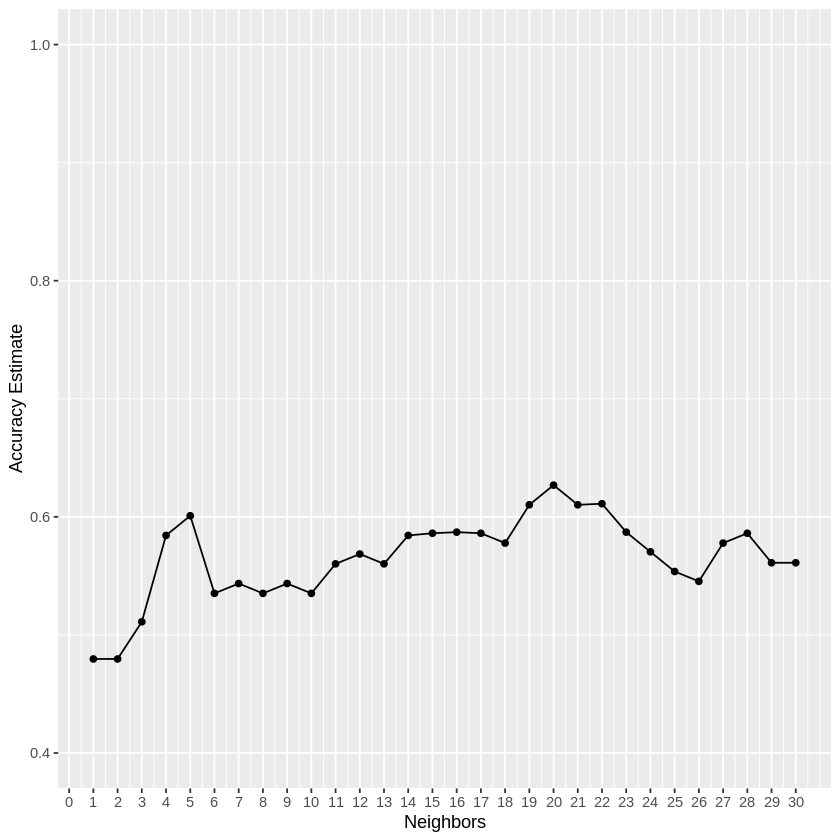

In [8]:
#filtering out the metrics to only display accuracy
accuracies <- countries_results %>% 
      filter(.metric == "accuracy")

#plotting out the k vs accuracy estimate in order to visualize the relationship between them.
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 30, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0))

cross_val_plot


#finding the k value with the highest accuracy
kmax <- accuracies %>%
    filter(mean == max(mean)) %>%
    pull(neighbors)

kmax

From the graph above we can choose the best $k$ value for our specifications. We will choose the $k$ = 20 value because it seems to be the most accurate and it most likely will not over-fit or under-fit.

In [9]:
set.seed(2) 

# creating new knn specification using the k value we got from the graph
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = kmax) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# creating the fit using the training data
countries_fit <- workflow() %>%
      add_recipe(countries_recipe) %>%
      add_model(knn_spec) %>%
      fit(data = countries_train)

In [10]:
set.seed(2) 

# predicting the GDP_classified of the test data
countries_predictions <- predict(countries_fit, countries_test) %>%
    bind_cols(countries_test)

countries_predictions

# finding the accuracy of the prediction
countries_metrics <- countries_predictions %>%
    metrics(truth = GDP_classified, estimate = .pred_class)

countries_metrics

# finding the confusion matrix of the prediction
countries_conf_mat <- countries_predictions %>%
    conf_mat(truth = GDP_classified, estimate = .pred_class)

countries_conf_mat

.pred_class,country,cropland.footprint,grazing.footprint,forest.footprint,fish.footprint,carbon.footprint,gdp.per.capita,GDP_classified
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
low,Madagascar,0.27,0.34,0.24,0.02,0.07,456.33,low
low,Malawi,0.43,0.05,0.20,0.01,0.07,493.84,low
low,Central African Republic,0.30,0.55,0.26,0.02,0.08,495.04,low
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
high,Singapore,0.67,0.24,0.91,0.22,5.91,53122.4,high
high,Australia,2.68,0.63,0.89,0.11,4.85,66604.2,high
high,Switzerland,0.75,0.22,0.38,0.07,4.26,88506.2,high


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6000000
kap,multiclass,0.4666667


              Truth
Prediction     low lower middle upper middle high
  low           10            6            1    0
  lower middle   0            2            2    0
  upper middle   0            2            4    2
  high           0            0            3    8

We can see that even with the most optimal $k$ value, we still have a very low accuracy. The algorithm seems to struggle the most with distinguishing between the lower middle and the low categories. This might be because some of the predictors are not the most accurate at determining the GDP.

We decided to find the two most accurate predictors of GDP's class in order to test this hypothesis. We referred to the literature and data available on this topic. 

According to "Source 2", "the ecological footprint (EF) measures the consumption of biological natural resources and it is expressed in productive land area needed to supply the goods and process the wastes of a given entity". EF can be considered as the sum of the cropland footprint, grazing footprint, forest footprint, fish footprint, carbon footprint and built-up footprint (Source 6), the first five of which were used as predictors of GDP in this report. 
According to "Source 1", there is a strong positive correlation between GDP and EF, so countries with higher GDP tend to have a higher EF per capita, and vice versa. 

The following graph by Source 7, shows world's EF record from 1961 to 2014. It can be observed that the top contributors to world EF have always been cropland footrpint and carbon footprint. Given that our data in this report is from 2016, we assume that cropland footprint and carbon footprint still remain as the top contributors. 

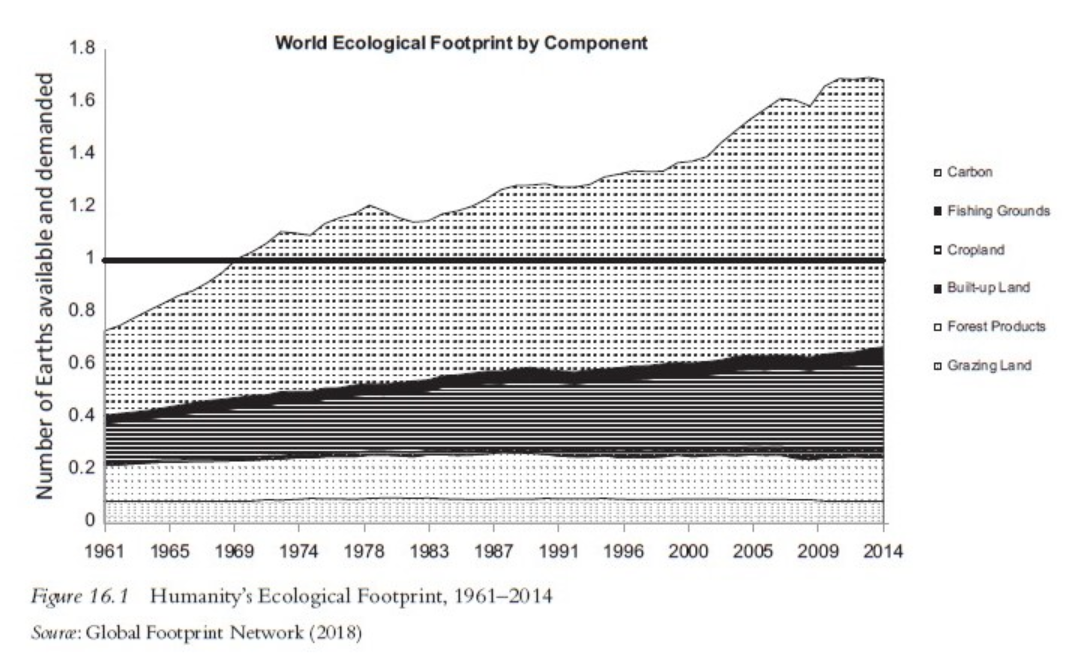

Therefore, given that the EF has a strong positive correlation with GDP, and given that cropland footprint and carbon footprint are the top two contributors to the EF, we will consider carbon footprint and cropland footprint as the potentially most accurate predictors of GDP out of the five original footprints that we used. 


Below, we used ggpairs, to give us an account of the correlation between GDP and each of the original predictors:

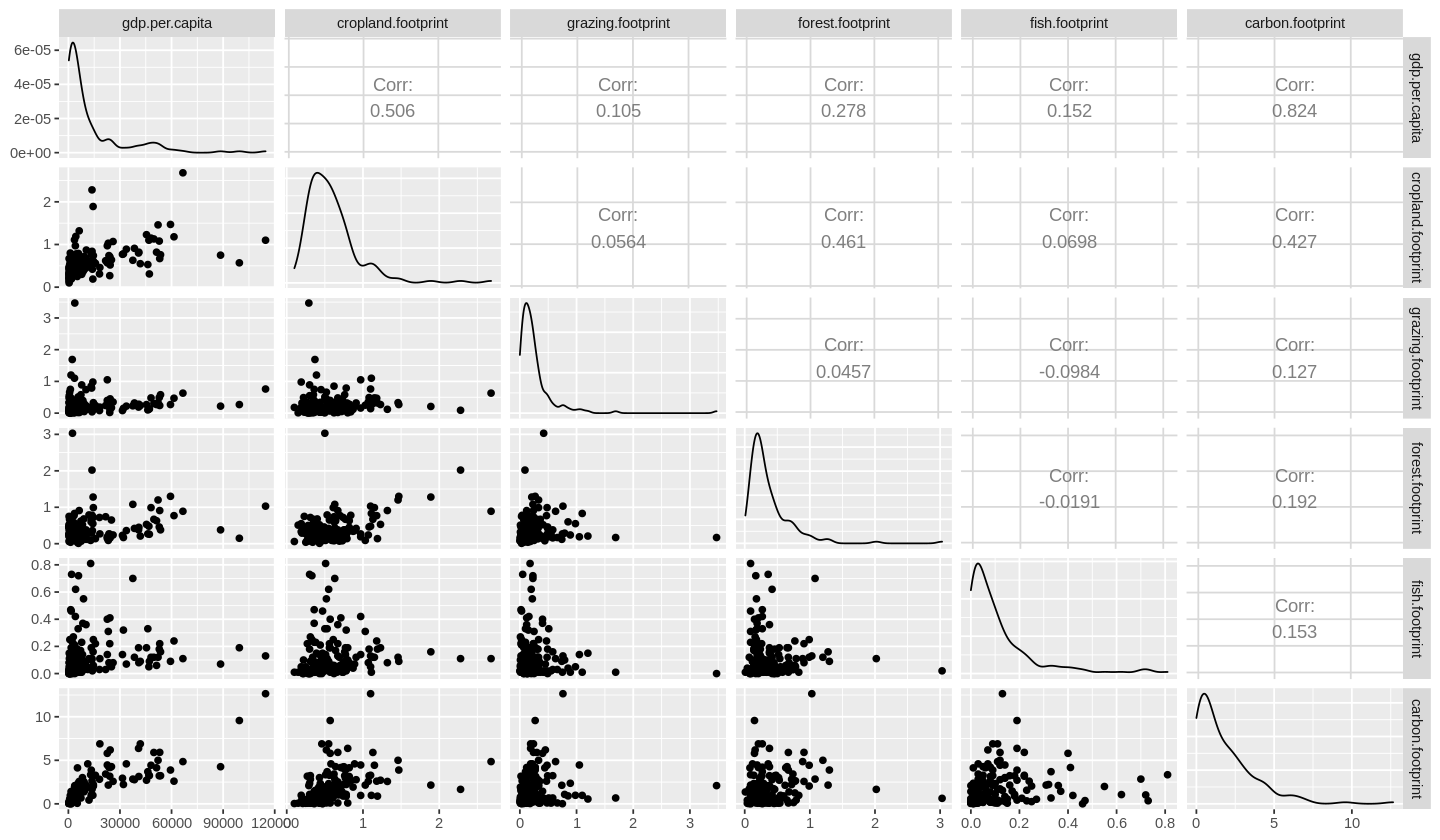

In [27]:
options(repr.plot.width = 12, repr.plot.height = 7)

plot_pairs <- countries_GDP_eco %>%
  select(gdp.per.capita, cropland.footprint, grazing.footprint, forest.footprint, 
         fish.footprint, carbon.footprint) %>%
  ggpairs()
plot_pairs

It can be observed that out of the five predictors, carbon footprint and cropland footprint showed the highest positive correlation with GDP, respectively. This provides another basis for our hypothesis, that the cropland footprint and carbon footprint will serve as more accurate predictors of GDP compared to the original five. 

After determining these two variables, which have a higher positive correlation with GDP, we will now regenerate and tune a new k-nearest classification model using only these two predictors. We will use the same process as we did to create the original classification model and use the same training and testing data. By doing so we can evaluate wether or not the accuracy of our model increases when only using the two variables with the highest correlation to GDP.

In [14]:
set.seed(3)
#creating our recipe
improved_countries_recipe <- recipe(GDP_classified ~ cropland.footprint + carbon.footprint, data = countries_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

#specifications for our model
improved_knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

#cross-validation
improved_countries_vfold <- vfold_cv(countries_train, v = 5, strata = GDP_classified)

grid_vals <- tibble(neighbors = seq(1, 30))

#workflow analysis metrics
improved_countries_results <- workflow() %>%
    add_recipe(improved_countries_recipe) %>%
    add_model(improved_knn_tune) %>%
    tune_grid(resamples = countries_vfold, grid = grid_vals) %>%
    collect_metrics()

improved_countries_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5833333,5,0.03726780,Model01
1,roc_auc,hand_till,0.7230159,5,0.02529742,Model01
2,accuracy,multiclass,0.5833333,5,0.03726780,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,roc_auc,hand_till,0.8381803,5,0.02426538,Model29
30,accuracy,multiclass,0.5907407,5,0.04388635,Model30
30,roc_auc,hand_till,0.8376512,5,0.02555281,Model30


The metrics are now used in order to graph out the $k$ value vs the Accuracy Estimate. We use this graph to find the best $k$ value for our dataset.

[1] 6

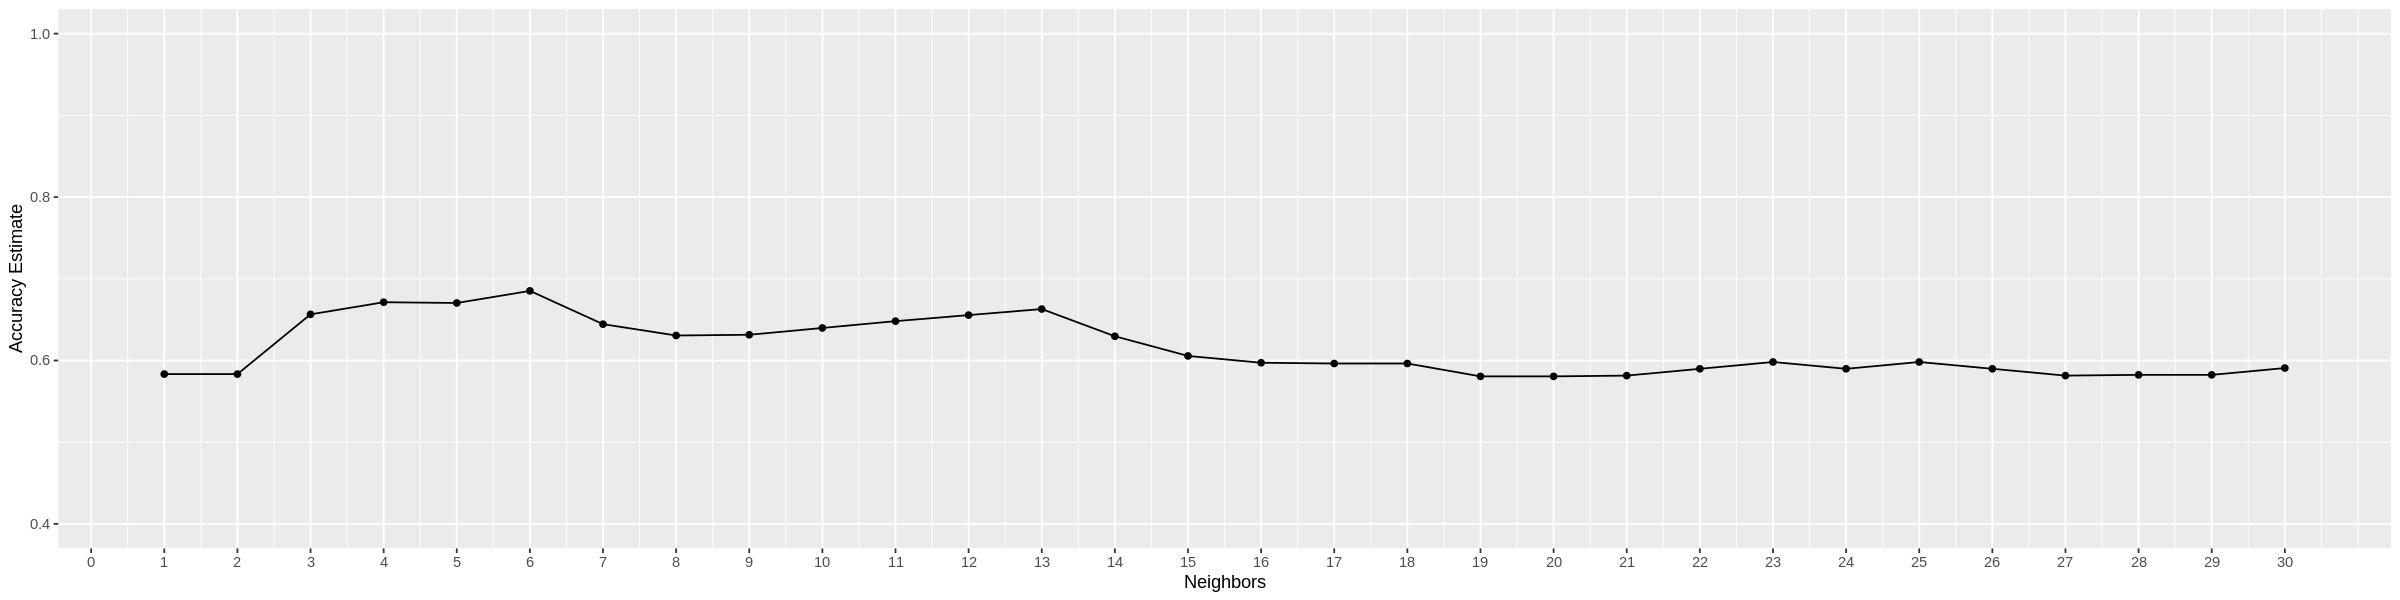

In [15]:
#filtering out the metrics to only display accuracy
improved_accuracies <- improved_countries_results %>% 
      filter(.metric == "accuracy")

#plotting out the k vs accuracy estimate in order to visualize the relationship between them.
improved_cross_val_plot <- ggplot(improved_accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 30, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0))

improved_cross_val_plot

#finding the k value with the highest accuracy
improved_kmax <- improved_accuracies %>%
    filter(mean == max(mean)) %>%
    pull(neighbors)

improved_kmax

This graph shows us that for our new model, $k$ = 6 will give us the most accurate results. We will now use this k value to construct an improved classification model and evaluate its accuracy.

In [16]:
set.seed(4) 

# creating new knn specification using the k value we got from the graph
improved_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = improved_kmax) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# creating the fit using the training data
improved_countries_fit <- workflow() %>%
      add_recipe(improved_countries_recipe) %>%
      add_model(improved_knn_spec) %>%
      fit(data = countries_train)

In [17]:
set.seed(4) 

# predicting the GDP_classified of the test data
improved_countries_predictions <- predict(improved_countries_fit, countries_test) %>%
    bind_cols(countries_test)

improved_countries_predictions

# finding the accuracy of the prediction
improved_countries_metrics <- improved_countries_predictions %>%
    metrics(truth = GDP_classified, estimate = .pred_class)

improved_countries_metrics

# finding the confusion matrix of the prediction
improved_countries_conf_mat <- improved_countries_predictions %>%
    conf_mat(truth = GDP_classified, estimate = .pred_class)

improved_countries_conf_mat

.pred_class,country,cropland.footprint,grazing.footprint,forest.footprint,fish.footprint,carbon.footprint,gdp.per.capita,GDP_classified
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
low,Madagascar,0.27,0.34,0.24,0.02,0.07,456.33,low
low,Malawi,0.43,0.05,0.20,0.01,0.07,493.84,low
low,Central African Republic,0.30,0.55,0.26,0.02,0.08,495.04,low
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
high,Singapore,0.67,0.24,0.91,0.22,5.91,53122.4,high
high,Australia,2.68,0.63,0.89,0.11,4.85,66604.2,high
high,Switzerland,0.75,0.22,0.38,0.07,4.26,88506.2,high


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7
kap,multiclass,0.6


              Truth
Prediction     low lower middle upper middle high
  low           10            3            0    0
  lower middle   0            5            3    0
  upper middle   0            1            4    1
  high           0            1            3    9

The metrics reported from our model show that with the use of only carbon and cropland footprint, we can achieve an accuracy of 70% in our model. This is a 10% increase from our previous model, which used all five footprints as predictors of a countries GDP.

Using only the carbon and cropland footprints, we still did not get a very accurate model. We had initially thought that the prediction accuracy would be around 80%.